# Chapter 12: How to build an XmR chart

For additional context see Chapter 12 of [The Virus of Variation](https://www.brokenquality.com/book). Questions? Email James.Lehner@gmail.com or QualityIsBroken@gmail.com.

In [1]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from process_improvement import comparison_charts as cc
import numpy as np
import seaborn as sns
import pandas as pd

%matplotlib inline

## Step 1: Gather the data

The dataset used in this chapter is called:

`impact-of-handwashing-death-to-birth-rates.csv`

The dataset can be found at https://github.com/jimlehner/the-virus-of-variation/tree/main/data.

In [2]:
# Establish the dataset_url
rate_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/impact-of-handwashing-death-to-birth-rates.csv'

# Get data function
def get_data(dataset_url) -> pd.DataFrame:
    return pd.read_csv(dataset_url)

# Get data
rate_df = get_data(rate_url)

# Drop unnecessary columns
rate_df = rate_df.drop(['Hospital', 'Month', 'Year', 'Births', 'Deaths'], axis=1)

# Specify 'Year' column dtype as string
rate_df['MonthYear'] = rate_df['MonthYear'].astype('string')

# Show dataframe
rate_df.head()

,Stage,MonthYear,Rate
0,Before handwashing,Jan-41,14.6
1,Before handwashing,Feb-41,7.5
2,Before handwashing,Mar-41,4.3
3,Before handwashing,Apr-41,1.6
4,Before handwashing,May-41,0.8


## Step 2: Calculate the moving ranges

In [3]:
# Calculate the moving ranges and add them to the DataFrame as the "Moving Range" column
rate_df['Moving Range'] = abs(rate_df['Rate'].diff())
# Step 2: explicitly set first value to NaN
rate_df.loc[rate_df.index[0], 'Moving Range'] = np.nan

# Show dataframe
rate_df.head()

,Stage,MonthYear,Rate,Moving Range
0,Before handwashing,Jan-41,14.6,NaN
1,Before handwashing,Feb-41,7.5,7.1
2,Before handwashing,Mar-41,4.3,3.2
3,Before handwashing,Apr-41,1.6,2.7
4,Before handwashing,May-41,0.8,0.8


## Step 3: Calculate the average moving range

In [4]:
# Calculate the average moving range
average_mR = rate_df['Moving Range'].mean()

# Print the average moving range
print('Average moving range:',average_mR)

Average moving range: 3.7864583333333335


## Step 4: Calculate the mean

In [5]:
# Calculate the mean
mean = rate_df['Rate'].mean()
print('Mean:',mean)

Mean: 8.619387755102041


## Step 5: Calculate the process limits

In [6]:
# Set values for the numeric constants C1 and C2
C1 = 2.660
C2 = 3.268

# Calculate the Upper Range Limit
UPL = round(mean + (C1*average_mR),2)

# Calculate the Lower Process Limit
LPL_calc = mean - (C1*average_mR)
# LPL with MAX condition
LPL = max(0, LPL_calc)

# Calculate the Upper Range Limit
URL = round(C2*average_mR,2)

# Show the results 
print('UPL:',UPL, 'LPL Calculated:',LPL_calc,'LPL:',LPL,'URL:',URL)

UPL: 18.69 LPL Calculated: -1.452591411564626 LPL: 0 URL: 12.37


## Step 6: Put it all together

In [11]:
# Round setting
round_value = 2

# Extract Data
data = rate_df['Rate']
labels = rate_df['MonthYear']
moving_ranges = rate_df['Moving Range']

# Define Process Limits
xchart_lines = [(mean, '-', 'black'), (UPL, '--', 'red'), (LPL, '--', 'red')]
mrchart_lines = [(average_mR, '-', 'black'), (URL, '--', 'red')]

# Mask values outside limits
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)

## Figure 12.4: XmR chart of death-to-birth rates

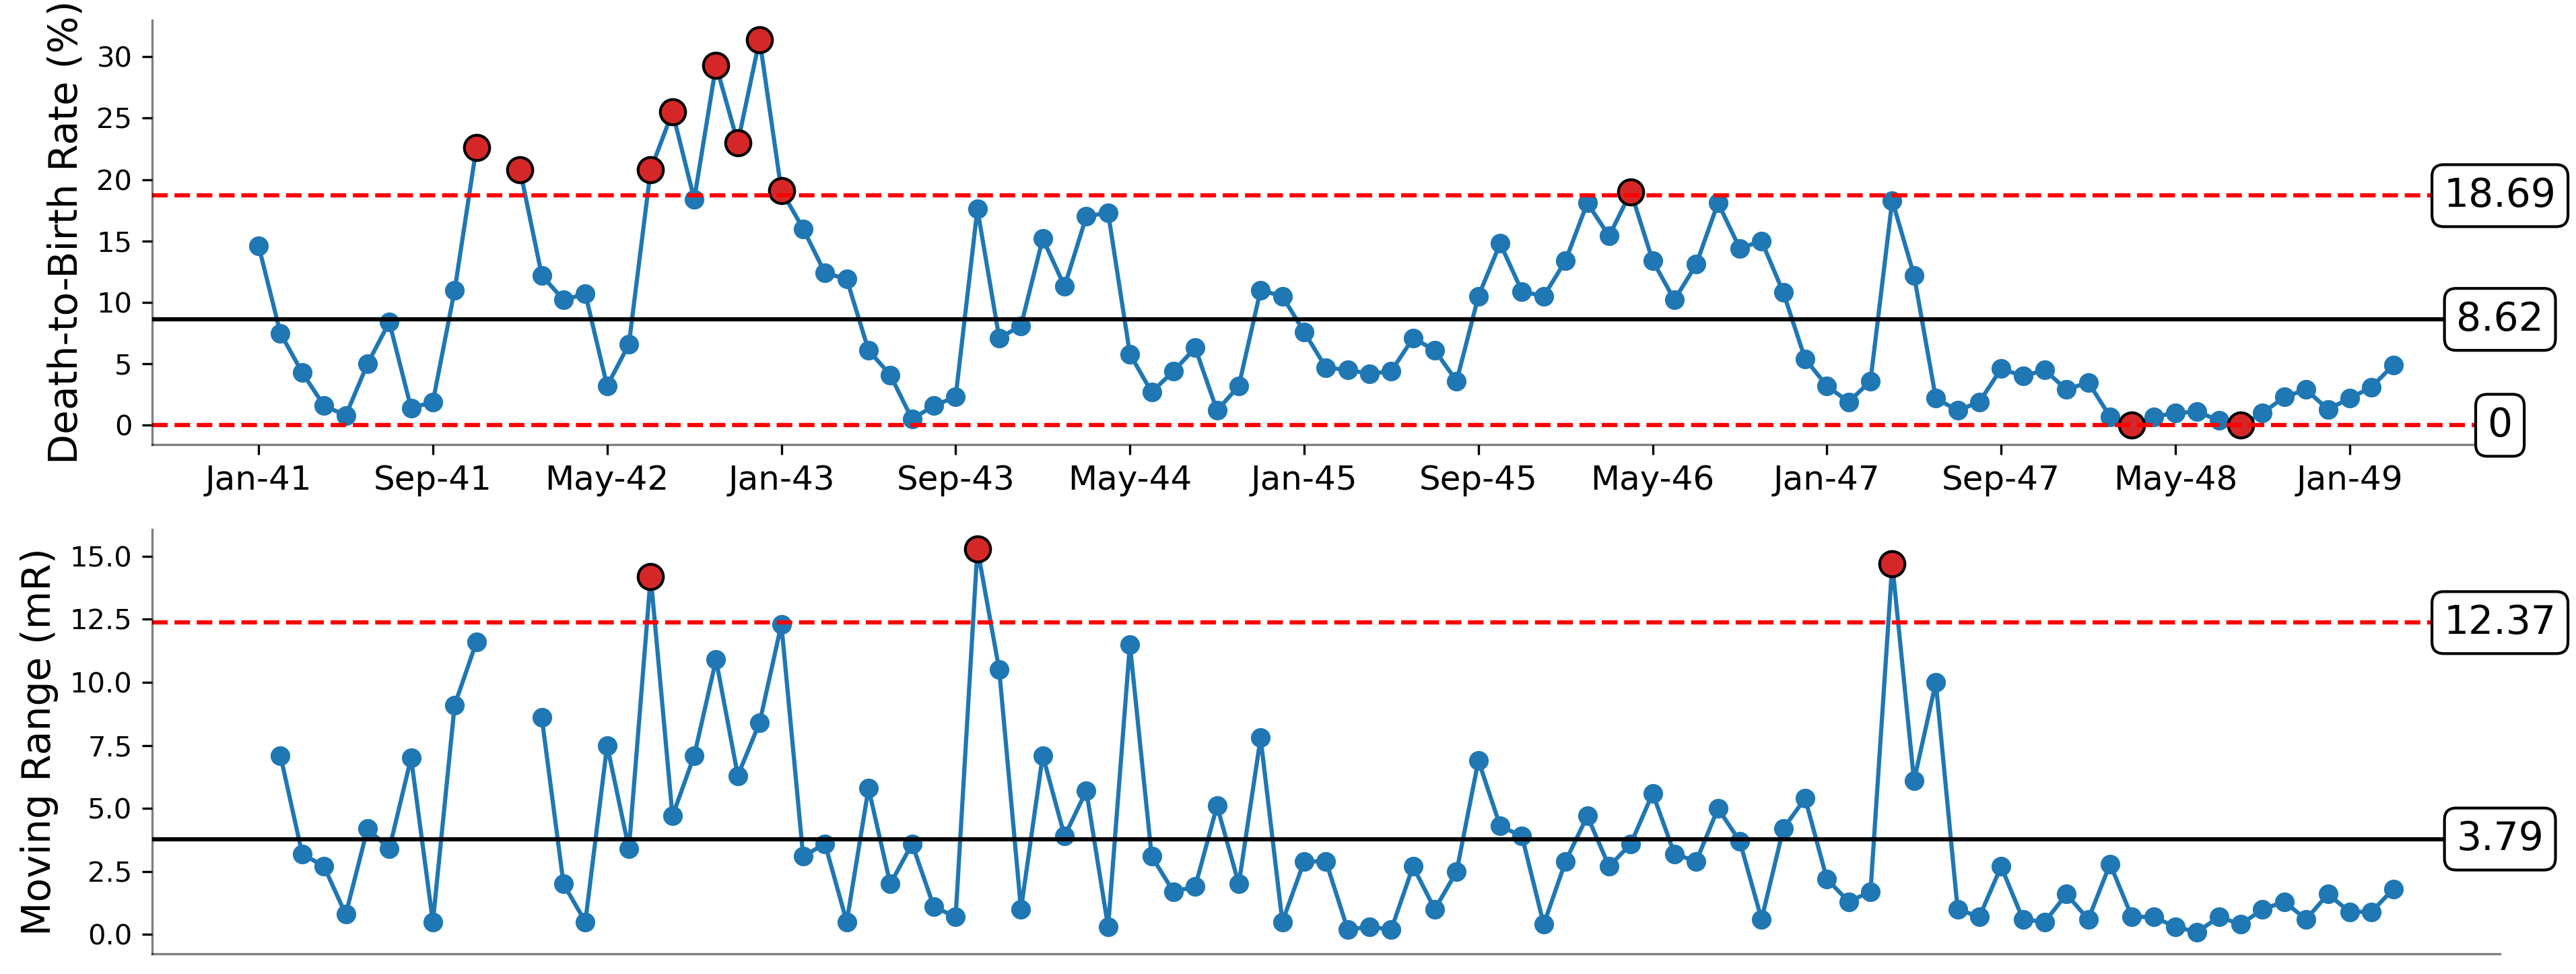

In [14]:
# Create figure and axs
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, ncols=1, dpi=300)

# X-Chart (Individuals Chart)
axs[0].plot(labels, data, marker='o', label="Data")
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Add Process Limits
for value, linetype, color in xchart_lines:
    axs[0].axhline(value, ls=linetype, c=color)

# Add Labels for Process Limits
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for value, label in [(UPL, UPL), (LPL, LPL), (mean, mean)]:
    axs[0].text(axs[0].get_xlim()[1], value, round(value, round_value),
                color='black', ha='center', va='center',
                fontsize=14, bbox=bbox_props)

# X-Axis Formatting
tick_interval = 8
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center', 
                       fontsize=12)

# Moving Range Chart (mR Chart)
axs[1].plot(labels, moving_ranges, marker='o', label="Moving Range")
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Optional: highlight missing points
for xi, yi in zip(labels, moving_ranges):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0) 

# Add Process Limits
for value, linetype, color in mrchart_lines:
    axs[1].axhline(value, ls=linetype, c=color)

# Add Labels for Process Limits
for value, label in [(URL, URL), (average_mR, average_mR)]:
    axs[1].text(axs[1].get_xlim()[1], value, round(value, round_value),
                color='black', ha='center', va='center',
                fontsize=14, bbox=bbox_props)

# Titles and Labels
axs[0].set_ylabel("Death-to-Birth Rate (%)", fontsize=14)
axs[0].set_xlabel("")
axs[0].set_title("")

# Remove xticks on moving range chart
axs[1].set_xticks([])
axs[1].set_ylabel("Moving Range (mR)", fontsize=14)

# Remove spines
sns.despine()
# Set alpha values
for val in range(0,2):
    axs[val].spines[['left','bottom']].set_alpha(0.5)

# Show Plot
plt.show()